# **A Primer On Neural Cellular Automata**

In [1]:
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL, einops
import fastcore.all as fc
import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

## **Background on Neural Cellular Automata(NCA)**

We'll be continuing with Johnathan Whitaker's excellent deep dives from [lesson 20](https://www.youtube.com/watch?v=PdNHkTLU2oQ&t=72s). 

This notebook covers the fascinating topic of [Neural Cellular Automata](https://distill.pub/2020/growing-ca/). In his notes, Johno's summary of NCA is:

> A cellular automaton is a discrete model that consists of a grid of cells, each of which can be in one of a finite number of states. The cells are updated simultaneously based on a set of rules that determine the state of a cell based on the states of its neighbors.
>
>Cellular automata are often used to model complex systems and can exhibit emergent behavior, meaning that patterns and >behaviors emerge from the interactions of the individual cells even though the rules governing their behavior are simple.
>
>Classic examples such as the famous 'Game of Life' have very simple rules and limit states to 'alive' or 'dead'. However, >the ideas can be extended to continuous outputs for each cell, and the update 'rule' can be a small neural network rather than a hard-coded decision tree - giving us 'Neural Cellular Automata'.


For additional reading, he also included links to the following papers, discussions and posts:

>Key references: 
>- [Growing Neural Cellular Automata](https://distill.pub/2020/growing-ca/) - A delightful paper that was my intro to the topic
>- [Texture Generation with NCA](https://arxiv.org/abs/2105.07299) - tiny models making amazing >textures, the paper we're replicating today.
>- ['The Future of Artificial Intelligence is Self-Organizing and Self-Assembling'](https://sebastianrisi.com/self_assembling_ai/) - More general discussion of this space
>- [Fixing Neural CA Colors with Sliced Optimal Transport](https://www.youtube.com/watch?v=ZFYZFlY7lgI) -  A follow-on video from Alexander Mordvintsev (include code for a different style loss)
>- [Fun with Neural Cellular Automata](https://wandb.ai/johnowhitaker/nca/reports/Fun-with-Neural-Cellular-Automata--VmlldzoyMDQ5Mjg0) - My W&B report with lots of examples

## **Style Matching with NCA**

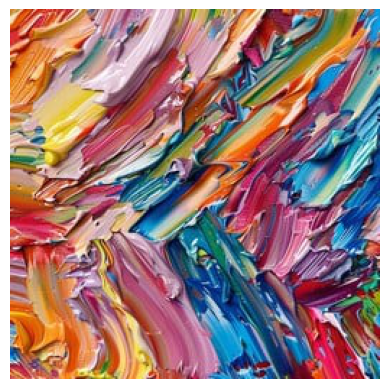

In [2]:
def download_image(url):
    imgb = fc.urlread(url, decode=False)
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

url = "https://images.stockcake.com/public/d/4/8/d483ae6d-f7f9-43c4-825b-55c0c8cf08e5_medium/vibrant-paint-strokes-stockcake.jpg"
style_im = download_image(url).to(def_device)
show_image(style_im);

### **Style Loss From NB_16A**

In [3]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

def calc_features(imgs, target_layers=[15, 25]):
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

# Using the batched version of the Gram matrix function
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('bchw, bdhw -> cd', x, x) / (x.shape[-2]*x.shape[-1])
             for x in calc_features(img, target_layers))

class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im[None], target_layers)

    def __call__(self, input_im):
        return sum((f1 - f2).pow(2).mean() for f1, f2 in 
                   zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [4]:
style_loss = StyleLossToTarget(style_im)
style_loss(torch.rand(1, 3, 256, 256).to(def_device))

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(854.5058, device='cuda:0', grad_fn=<AddBackward0>)